# Cholesterol serem, Gender and Age to predict the pressence of heart disease patients from Cleveland
### Alina Hameed, San Kang, Siddarth Chilukuri, Sehan Malhotra

### Introduction:

In the medical field, doctors and other healthcare professionals have consistently sought ways to enhance patient health, detect early signs of illness, and facilitate timely intervention. They have explored various factors, such as diet, blood type, etc to alert individuals to potential health risks. **In this project, we will utilize easily accessible patient characteristics to predict the risk of developing heart disease, specifically focusing on serum cholesterol levels measured in mg/dL, age and sex.**

The "goal" field in the dataset indicates the presence of heart disease in patients is assigned integer values ranging from 0 (no presence) to 4. Previous experiments with the Cleveland database have primarily aimed at distinguishing between the presence of heart disease (values 1, 2, 3, 4) and its absence (value 0). 


### Preliminary exploratory data analysis

In [42]:
## loading in libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("readxl")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [48]:
## reading csv, cleaning data
data <- read_csv(url("https://drive.google.com/uc?export=download&id=1aEyDR_0h4FG2FtFKyL_RbKkyNinISWPX")) 

data <- data |> mutate(diagnosis = condition)

data <- data |>
  mutate(across(
    diagnosis,
    ~ recode(., "0" = FALSE, "1" = TRUE)
  ))

data <- data |>
  mutate(across(
    sex,
    ~ recode(., "0" = "female", "1" = "male")
  ))

data <- data |> select(chol, age, sex, diagnosis)

write_csv(data, "data/prelim.csv")

set.seed(1232) 

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [49]:
## training data
data <- data |> mutate(diagnosis = as.factor(diagnosis)) 

data_split <- data |> initial_split(prop = 0.75, strata = diagnosis)  
data_training <- training(data_split)   
data_testing <- testing(data_split)

head(data_training)
head(data_testing)

chol,age,sex,diagnosis
<dbl>,<dbl>,<chr>,<fct>
239,69,female,FALSE
226,66,female,FALSE
227,64,male,FALSE
240,60,female,FALSE
283,58,female,FALSE
193,56,male,FALSE


chol,age,sex,diagnosis
<dbl>,<dbl>,<chr>,<fct>
234,69,male,FALSE
211,64,male,FALSE
233,63,male,FALSE
234,61,male,TRUE
270,59,male,FALSE
273,59,male,TRUE


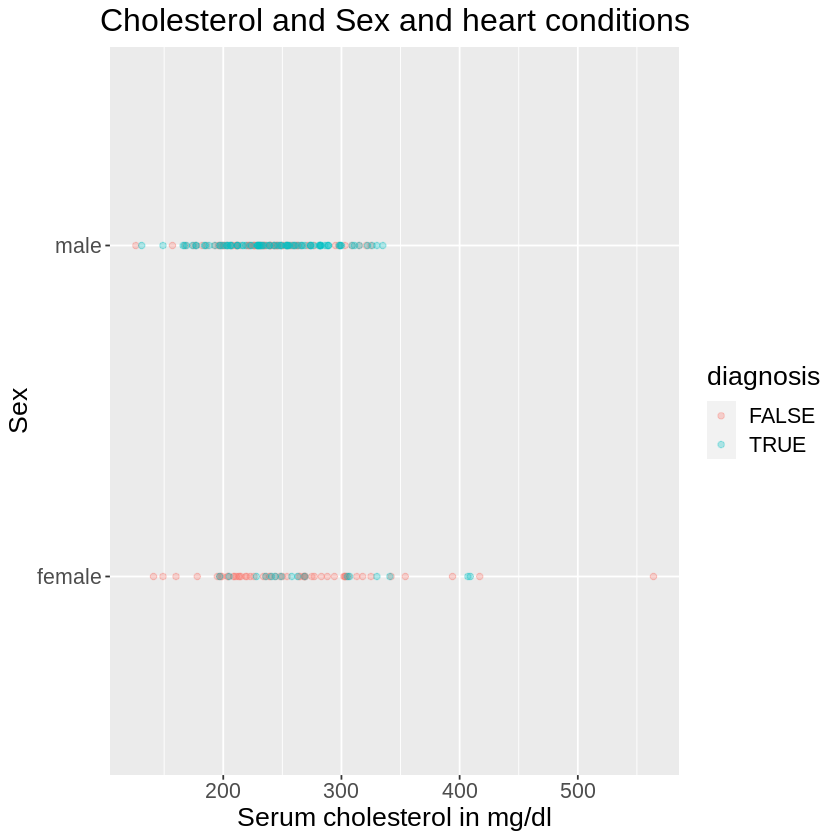

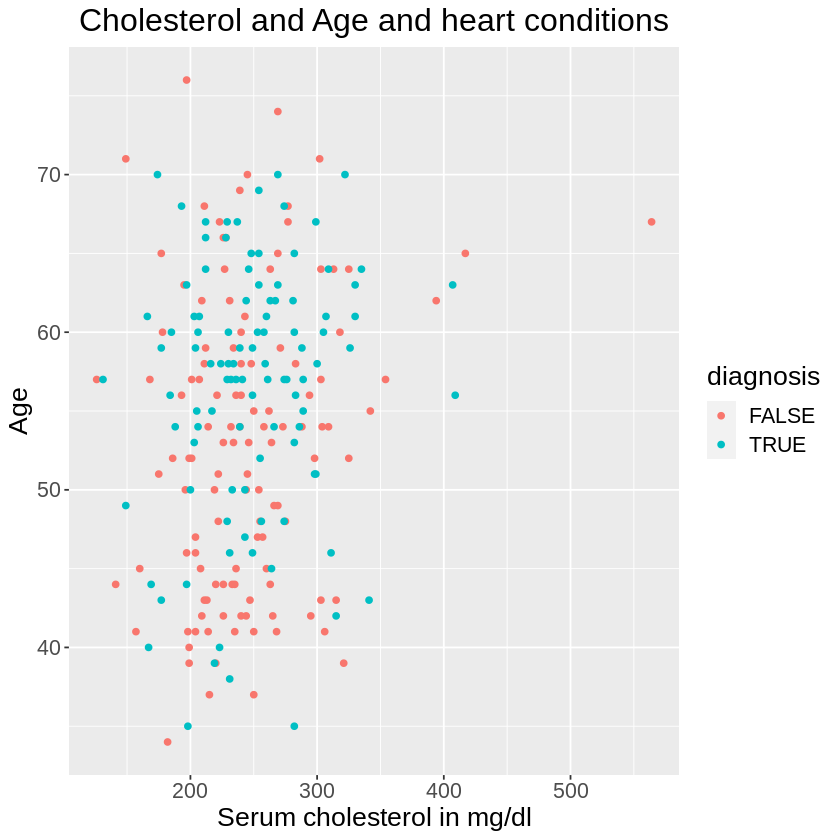

In [50]:
##plotting

#ploting cholesterol and sex
plot_chol_sex <- data_training |> ggplot(aes(x = chol, y = sex)) +
                    geom_point(alpha = 0.3, aes(colour = diagnosis)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Sex", title = "Cholesterol and Sex and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))
plot_chol_sex

#plotting cholesterol and age
plot_chol_age <- data_training |> ggplot(aes(x = chol, y = age)) +
                    geom_point(alpha = 1, aes(colour = diagnosis)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Age", title = "Cholesterol and Age and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))
plot_chol_age

### Methods

We first used select() to select the chol (Serum Cholesterol levels), age, sex, and condition (0 if the individual does not have the condition, 1 if they do) columns from our dataframe. Then, we used mutate() to mutate the condition column of the data to be “No” if the value is 0 and “Yes” if it is 1. Finally, we used mutate() to make the condition a factor and then used initial_split() to split our dataframe in a 3:1 ratio.

Because of its non-parametric nature, we plan on using the K Nearest Neighbors classification algorithm to identify if an individual has a heart condition based on their sex, age, and serum cholesterol levels. We chose these variables because they are relatively easy for patients to access and to also ensure that our classification is not influenced by other variables that have a lower correlation with the condition variable. We plan on creating a scatter plot using ggplot() to visualize, observe, and understand the final results and the relationship between the variables.



### Expected outcomes and significance

We expect that men will have a higher chance of having a heart condition based on the data. In terms of serum cholesterol levels, we expect that a higher value corresponds to a greater chance of having a heart condition. Finally, we expect that individuals below the age of 35 are less likely to have a heart condition. This will help hospitals and large medical institutions in planning their treatment procedure and resource allocation better and in accordance with these 3 categories. Furthermore, using the impact of age, sex and serum cholesterol levels can help arguably debunk myths and misconceptions about these heart diseases.These findings could lead to an investigation into this relationship based on demography. Currently, we are observing the relationship of age, sex, and serum cholesterol levels for individuals in Cleveland. Expanding our analysis to other parts of the world can showcase how different demographic locations foster different lifestyles, portraying how our analysis may change. 

